# TO-DO

Pull code from GitHub (Eva's pushed code)

## Create Visualizations

The code below creates a sample reply tree and reply graph visualization and saves them to two files. This is okay, but we should update the visualizations to be prettier (they should be added to the report).

The updates that should be made are the following:
- For the reply tree, we should remove the labels that are added within the circles of the nodes (tweet id). These do not add information that is useful to have. We should add some color to the tree (e.g., node color, edge color, root node different background color?)
- For the reply graph, current visualizations are way too dense and the edges are unorganized. Look at the slides from Week 4 for examples how the visualizations should look. We should make this much prettier.

Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt', reply_tweets='congress_df_2022-10-26_reply_tweets.txt', reply_mappings='congress_df_2022-10-26_reply_mappings.txt')
1637 1637


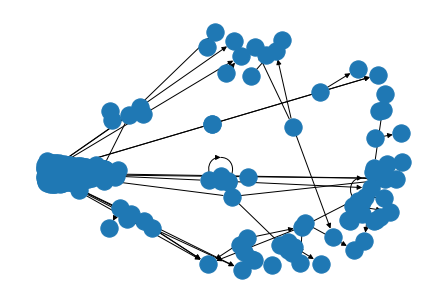

In [1]:
%run create_visualizations.py --initial_tweets congress_df_2022-10-26_tweets.txt --reply_tweets congress_df_2022-10-26_reply_tweets.txt --reply_mappings congress_df_2022-10-26_reply_mappings.txt 

## Create DataFrame with ML Features

First, play around to compute some features. Then, make it modular and put it in original code.

Democrats tend to tweet more than republicans; democrats tend to have more followers than republicans; democrats tend to follow more people than republicans

### Import Packages

In [45]:
import ast
import create_reply_trees as crt
import numpy as np
import pandas as pd
import networkx
import treelib
import json
import math

### Get tree and graph dictionaries to play around with

In [2]:
from argparse import Namespace

flags = Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt',
                  reply_tweets='congress_df_2022-10-26_reply_tweets.txt',
                  reply_mappings='congress_df_2022-10-26_reply_mappings.txt'
                  )

In [3]:
cid_tree_dict, cid_graph_dict = crt.create_reply_trees_and_graphs(
        flags.reply_tweets, flags.initial_tweets, flags.reply_mappings
    )

Number of reply cids found: 1439
Length of cid_tree_dict: 1623, length of cid_graph_dict: 1623
Built mapping dictionaries.
Added nodes to trees and graphs.
Rerordered trees.
Added graph edges.


In [4]:
for cid, tree in cid_tree_dict.items():
    tree.show()
    break

1587162493889044480
├── 1587300669165371393
│   └── 1587954945449676801
├── 1587407704703868930
├── 1587448547846541315
├── 1587506382932217858
└── 1588007002483134467



### Initialize DataFrame

In [5]:
conv_df = pd.DataFrame(index=cid_tree_dict.keys())

In [6]:
conv_df['tree_size'] = np.zeros(len(conv_df))
conv_df['tree_depth'] = np.zeros(len(conv_df))
conv_df['tree_lvl1_breadth'] = np.zeros(len(conv_df))
conv_df['tree_breadth'] = np.zeros(len(conv_df))
conv_df['tree_out_degree_avg'] = np.zeros(len(conv_df))
conv_df['tree_max_replies_exc_orig'] = np.zeros(len(conv_df))
conv_df['tree_dropped_node_count'] = np.zeros(len(conv_df))

conv_df['orig_retweet_count'] = np.zeros(len(conv_df))
conv_df['orig_like_count'] = np.zeros(len(conv_df))
conv_df['orig_quote_count'] = np.zeros(len(conv_df))

### Compute Tree Features

In [7]:
for cid, tree in cid_tree_dict.items():
    # Basic metrics
    conv_df['tree_size'][cid] = tree.size()
    conv_df['tree_depth'][cid] = tree.depth()
    conv_df['tree_lvl1_breadth'][cid] = tree.size(level=1)
    conv_df['tree_breadth'][cid] = len(tree.leaves())
    
    # Calculation metrics
    out_degree = 0
    max_children = 0
    for node in tree.all_nodes():
        out_degree += len(tree.children(node.tag))
        if node.is_root() == False and len(tree.children(node.tag)) > max_children:
            max_children = len(tree.children(node.tag))
            
    conv_df['tree_out_degree_avg'][cid] = out_degree/tree.size()
    conv_df['tree_max_replies_exc_orig'][cid] = max_children
    
    # Use data in tree to define metrics
    conv_df['tree_dropped_node_count'][cid] = tree[tree.root].data['dropped_node_count']
    conv_df['orig_retweet_count'][cid] = tree[tree.root].data['retweet_count']
    conv_df['orig_like_count'][cid] = tree[tree.root].data['like_count']
    conv_df['orig_quote_count'][cid] = tree[tree.root].data['quote_count']
    
    
    # What other metrics can or do we want to define for trees?
      # Something super duper original.................
      # Weighted sum of follower count (by appearance)
      # If we really want to, use verified, mentions and time information we have in the data

### Compute Graph Features

In [55]:
conv_df['graph_user_count'] = np.zeros(len(conv_df))
conv_df['graph_edge_per_user_count'] = np.zeros(len(conv_df))
conv_df['graph_in_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_out_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_avg_out_degree'] = np.zeros(len(conv_df)) # you reply
conv_df['graph_avg_in_degree'] = np.zeros(len(conv_df)) # replies to you

conv_df['graph_nr_conn_comp'] = np.zeros(len(conv_df))
conv_df['graph_max_degree_exc_orig'] = np.zeros(len(conv_df))
conv_df['graph_reciprocity'] = np.zeros(len(conv_df))
conv_df['graph_density'] = np.zeros(len(conv_df))

conv_df['graph_degree_assortativity'] = np.zeros(len(conv_df))
conv_df['graph_dropped_node_count'] = np.zeros(len(conv_df))
conv_df['graph_dropped_edge_count'] = np.zeros(len(conv_df))

conv_df['graph_author_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_author_following_count'] = np.zeros(len(conv_df))
conv_df['graph_author_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_author_listed_count'] = np.zeros(len(conv_df))

conv_df['graph_avg_user_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_following_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_listed_count'] = np.zeros(len(conv_df))
conv_df['graph_user_verified_frac'] = np.zeros(len(conv_df))

In [59]:
for cid, graph in cid_graph_dict.items():
    conv_df['graph_user_count'][cid] = graph.number_of_nodes()
    conv_df['graph_edge_per_user_count'][cid] = graph.number_of_edges()/graph.number_of_nodes()
    
    tree = cid_tree_dict[cid]
    orig_author_id = tree[tree.root].data['author_id']
    
    conv_df['graph_in_degree_author'][cid] = graph.in_degree(orig_author_id)
    conv_df['graph_out_degree_author'][cid] = graph.out_degree(orig_author_id)
    
    conv_df['graph_avg_out_degree'][cid] = np.mean([deg for (node, deg) in graph.out_degree()])
    conv_df['graph_avg_in_degree'][cid] = np.mean([deg for (node, deg) in graph.in_degree()])
        
    graph_und = graph.to_undirected()
    conv_df['graph_nr_conn_comp'][cid] = networkx.number_connected_components(graph_und)
    
    try:
        conv_df['graph_max_degree_exc_orig'][cid] = max([deg for (node, deg) in graph.degree() if node!=orig_author_id])
    except:
        pass
    
    try:
        conv_df['graph_reciprocity'][cid] = networkx.reciprocity(graph)
    except:
        pass
    
    conv_df['graph_density'][cid] = networkx.density(graph)
    
    if np.isnan(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif math.isinf(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif networkx.degree_assortativity_coefficient(graph) in (None, ''):
        conv_df['graph_degree_assortativity'][cid] = 0
    else:
        conv_df['graph_degree_assortativity'][cid] = networkx.degree_assortativity_coefficient(graph)
        
    conv_df['graph_dropped_node_count'][cid] = graph.graph['dropped_node_count']
    conv_df['graph_dropped_edge_count'][cid] = graph.graph['dropped_edge_count']
    
    conv_df['graph_author_follower_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['followers_count']
    conv_df['graph_author_following_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['following_count']
    conv_df['graph_author_tweet_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['tweet_count']
    conv_df['graph_author_listed_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['listed_count']
    
    user_follower_count = 0
    user_following_count = 0
    user_tweet_count = 0
    user_listed_count = 0
    user_verified_count = 0
    
    for node in graph.nodes:
        if node != orig_author_id:
            try:
                user_metrics = ast.literal_eval(graph.nodes[node]['public_metrics'])
                user_follower_count += user_metrics['public_metrics']['followers_count']
                user_following_count += user_metrics['public_metrics']['following_count']
                user_tweet_count += user_metrics['public_metrics']['tweet_count']
                user_listed_count += user_metrics['public_metrics']['listed_count']
                user_verified_count += 1 if user_metrics['verified']==True else 0 
            except:
                pass
        
    if graph.number_of_nodes() != 1:
        conv_df['graph_avg_user_follower_count'][cid] = user_follower_count/graph.number_of_nodes()
        conv_df['graph_avg_user_following_count'][cid] = user_following_count/graph.number_of_nodes()
        conv_df['graph_avg_user_tweet_count'][cid] = user_tweet_count/graph.number_of_nodes()
        conv_df['graph_avg_user_listed_count'][cid] = user_listed_count/graph.number_of_nodes()
    conv_df['graph_user_verified_frac'][cid] = (user_verified_count+1)/graph.number_of_nodes() # all congress members are verified

C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()


In [61]:
conv_df

,tree_size,tree_depth,tree_lvl1_breadth,tree_breadth,tree_out_degree_avg,tree_max_replies_exc_orig,tree_dropped_node_count,orig_retweet_count,orig_like_count,orig_quote_count,...,graph_dropped_edge_count,graph_author_follower_count,graph_author_following_count,graph_author_tweet_count,graph_author_listed_count,graph_avg_user_follower_count,graph_avg_user_following_count,graph_avg_user_tweet_count,graph_avg_user_listed_count,graph_user_verified_frac
1587162493889044480,7.0,2.0,5.0,5.0,0.857143,1.0,0.0,18.0,119.0,2.0,...,0.0,513299.0,345.0,9168.0,4531.0,375.571429,767.000000,7362.142857,5.000000,0.142857
1586007771207671809,13.0,4.0,9.0,9.0,0.923077,1.0,0.0,33.0,167.0,2.0,...,0.0,513299.0,345.0,9168.0,4531.0,354.727273,381.818182,9285.363636,1.454545,0.090909
1587835066520068096,4.0,1.0,3.0,3.0,0.750000,0.0,0.0,2.0,15.0,0.0,...,0.0,261964.0,3445.0,14193.0,3127.0,220.250000,260.500000,14286.000000,2.250000,0.250000
1587551050436816897,2.0,1.0,1.0,1.0,0.500000,0.0,0.0,3.0,8.0,0.0,...,0.0,261964.0,3445.0,14193.0,3127.0,77.000000,111.000000,8741.000000,4.000000,0.500000
1587088378461360129,5.0,1.0,4.0,4.0,0.800000,0.0,0.0,4.0,17.0,1.0,...,0.0,261964.0,3445.0,14193.0,3127.0,79.600000,263.400000,5355.800000,2.400000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587445605969829895,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,5.0,26.0,0.0,...,0.0,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000
1587127271051042816,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,9.0,14.0,0.0,...,0.0,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000
1587082397895593985,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,23.0,26.0,0.0,...,0.0,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000
1586756248833167361,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,7.0,19.0,0.0,...,0.0,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000


### Compute output measure

In [62]:
congress_df = pd.read_csv('congress_df_2022-10-26.csv', index_col=0)

In [63]:
congress_df['twitter_id'] = congress_df['twitter_id'].astype(str)

In [64]:
conv_df['y'] = np.zeros(len(conv_df))

In [65]:
for cid, tree in cid_tree_dict.items():
    author_id = tree[tree.root].data['author_id']
    index_author = np.where(congress_df['twitter_id']==author_id)[0][0]
    party = congress_df['party'].iloc[index_author]
    if party=='Democrat':
        conv_df['y'][cid] = 1

## Do Some Classification

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [79]:
X = conv_df.loc[:, conv_df.columns!='y']
y = conv_df['y']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [110]:
clf = DecisionTreeClassifier(random_state=1, max_depth=12)

In [111]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=1)

In [112]:
y_hat = clf.predict(X_test)
np.sum(y_hat == y_test)/len(y_test)

0.8078817733990148